## Introdução e Objetivos

A pandemia da Covid-19 teve seu início ao final de 2019, com um surto causado pelo Sars-Cov-2 na província de Wuhan, na China. Pouco mais de dois anos depois, ainda estamos lidando com esse cenário caótico através de mudanças no nosso cotidiano, como o uso de máscaras, distanciamento social e higienização constante de mãos e do ambiente, além de termos que nos adaptar ao surgimento de novas variantes enquanto corremos no avanço das vacinas.</br>
Atualmente, a variante mais importante é a Ômicron, que, apesar de caracterizada por uma baixa taxa de mortalidade, possui uma alta taxa de infecção, gerando uma grande quantia de infectados, e, por consequência, uma quantidade de mortes que não pode ser ignorada. Estimar o comportamento de um vírus é uma forma de prevenção e possibilita evitar uma tragédia ainda maior, ao mesmo tempo que nos trás passos para um retorno gradiente às nossas vidas normais.</br>
Neste projeto, tentaremos explicar a situação atual da Covid-19 em Pernambuco, bem como prever o estado da pandemia ao final do mês de julho. Para isso, usaremos conhecimentos de estatística e cálculo para estabelecer um modelo epidemiológico razoável, utilizando de bibliotecas da linguagem Python (NumPy, SciPy) para resolver ODEs e assim conseguir previsões, representadas graficamente com auxílio da Matplotlib. Por consequência, será uma importante prática de modelagem matemática para um problema do mundo real.

In [17]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [18]:
# Total population, N.
N = 1000

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0

# Everyone else, S0, is susceptible to infection initially
S0 = N - I0 - R0

# Contact rate, beta (in 1/days/#individuals), and mean recovery rate, gamma (in 1/days).
beta, gamma = 0.2/N, 1/10

# A grid of time points (in days)
t = np.linspace(0, 160, 160)

In [19]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [20]:
# Initial conditions vector
y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

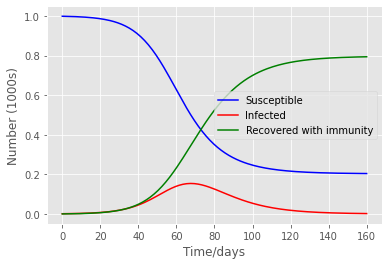

In [21]:
plt.plot(t, S/N, 'b', label='Susceptible')
plt.plot(t, I/N, 'r', label='Infected')
plt.plot(t, R/N, 'g', label='Recovered with immunity')
plt.xlabel('Time/days')
plt.ylabel('Number (1000s)')
plt.legend()
plt.show()